Best k = 20
Classification accuracy for test data = 54.90196078431373 %


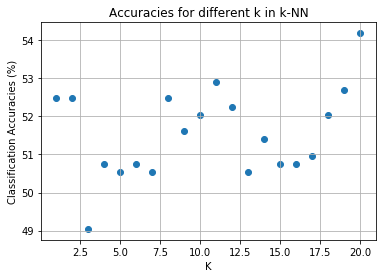

In [14]:
import csv
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import preprocessing 
import numpy as np
from numpy import genfromtxt
from operator import itemgetter
import scipy
import matplotlib.pyplot
import pylab

h = {}
with open('train.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    h['X'] = 0
    i=0
    for row in readCSV:
        if(i!=0):
            break
        i+=1
        for j in range(1,len(row)):
            h[row[j]] = j

entire_train_data = genfromtxt('train.csv', delimiter=',')
entire_train_data = entire_train_data[1:]
entire_test_data = genfromtxt('test.csv', delimiter=',')
entire_test_data = entire_test_data[1:][:]

def SearchK(k, curr):
        sortedarr = sorted(curr, key=itemgetter(0))
        vote = 0
        firstvote = 0
        for i in range(k):
            removed = sortedarr.pop(0)
            vote += removed[1]
            if(i==0):
                firstvote += removed[1]
        if(vote > k/2):
            return 1
        elif(vote < k/2):
            return 0
        else:
            return firstvote

def FindClassificationAccuracy(K, valid_test_data, valid_train_data):
    train_data = valid_train_data
    test_data = valid_test_data
    
    train_data_classes = [1 if train_data[x][-1]>0 else 0 for x in range(len(train_data))]

    data = np.transpose(train_data)
    columns_to_normalize = len(data)-1  
    ms = []
    norm_train_data = data
    for i in range(columns_to_normalize):
        curr = data[i]
        ms.append([np.mean(curr), np.std(curr)])  
        for j in range(len(curr)):
            norm_train_data[i][j]= (curr[j] - ms[i][0])/ms[i][1]
            
    test_data_classes = [1 if test_data[x][-1]>0 else 0 for x in range(len(test_data))]
    norm_test_data = np.transpose(test_data)

    for i in range(columns_to_normalize):
        curr = norm_test_data[i]
        for j in range(len(curr)):
            norm_test_data[i][j]= (norm_test_data[i][j] - ms[i][0]) / ms[i][1]

    d1 = pd.DataFrame(norm_test_data) 
    d2 = pd.DataFrame(norm_train_data)
    d1 = d1.T
    d2 = d2.T 
    d1 = d1.drop([12], axis=1)
    d2 = d2.drop([12], axis=1)
    
    euc_dist_list = scipy.spatial.distance.cdist(d1.iloc[:,:], d2.iloc[:,:], metric='euclidean')
    
    data_for_knn=[]
    for i in range(len(euc_dist_list)):
        curr_euc_dist = euc_dist_list[i]
        l = []
        for j in range(len(curr_euc_dist)):
            l.append([curr_euc_dist[j], train_data_classes[j]])
        data_for_knn.append(l)

    knn_result = []
    for i in range(len(data_for_knn)):
        knn_result.append(SearchK(K,data_for_knn[i]))

    error = np.sum([np.abs(a_i - b_i) for a_i, b_i in zip(knn_result, test_data_classes)])
    
    no_of_samples_correctly_classified = len(knn_result)-error
    classification_accuracy = no_of_samples_correctly_classified/len(knn_result)
    return classification_accuracy

np.random.shuffle(entire_train_data)

S = 5
slice_size = int(len(entire_train_data)/S)
validation_data = []

for i in range(S):
    sliced_test_data = entire_train_data[i*slice_size:(i+1)*slice_size]    
    front = entire_train_data[:i*slice_size]
    back = entire_train_data[(i+1)*slice_size:]    
    sliced_train_data=np.array(list(front)+list(back))    
    validation_data.append([sliced_test_data, sliced_train_data])

ca_list = []   
knn_max = 21
for k in range(1, knn_max):
    ca = 0
    for i in range(S):
        test = validation_data[i][0]
        train = validation_data[i][1]
        curr = FindClassificationAccuracy(k, test, train)
        ca += curr
    ca_list.append(ca/S)
    
best_k = ca_list.index(max(ca_list))+1    
print('Best k =', best_k)
ca_final = FindClassificationAccuracy(best_k, entire_test_data, entire_train_data)
print('Classification accuracy for test data =', ca_final*100, '%')

fig = plt.figure()
plt.scatter([i for i in range(1,knn_max)], [i*100 for i in ca_list] )
plt.xlabel('K')
plt.ylabel('Classification Accuracies (%)')
plt.title('Accuracies for different k in k-NN')
plt.grid()
plt.show()